In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from glob import glob
from datetime import datetime
import sys
import itertools
import dask
import dask.dataframe as dd 

sys.path.append('/projects/dedu0223/spicy-snow/')

from spicy_snow.processing.snow_index import calc_delta_cross_ratio, calc_delta_gamma, \
    clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth
from spicy_snow.processing.wet_snow import id_newly_wet_snow, id_wet_negative_si, \
    id_newly_frozen_snow, flag_wet_snow


In [54]:
def add_s1_depths(row):
    c = row.C
    #print(f'    {c}')
    
    ds = calc_snow_index_to_snow_depth(dsB, C=c, inplace=False)
    rmse_wet, rmse = get_rmse(ds, closest_ts)
    return rmse_wet, rmse

def get_rmse(ds, closest_ts):
    mask_wet = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)) | 
                        ds['wet_snow'].sel(time=closest_ts).astype(bool))
    diff_wet = ds['lidar-sd'].where(mask_wet) - ds['snow_depth'].sel(time=closest_ts).where(mask_wet)
    rmse_wet = float(np.sqrt((diff_wet**2).sum()/len(diff_wet.values.flatten())))

    
                # Compare snow depths - no wet snow mask
    mask = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)))
    diff = ds['lidar-sd'].where(mask) - ds['snow_depth'].sel(time=closest_ts).where(mask)
    rmse = float(np.sqrt((diff**2).sum()/len(diff.values.flatten())))
    
    return rmse_wet, rmse

def change_b(ds, b):
    ds = calc_delta_gamma(dsA, B=b, inplace=False)
    ds = clip_delta_gamma_outlier(ds)
    ds = calc_snow_index(ds)
    ds = id_newly_wet_snow(ds)
    ds = id_wet_negative_si(ds)
    ds = id_newly_frozen_snow(ds)
    ds = flag_wet_snow(ds)
    return ds

In [59]:
A = np.arange(1, 3.1, 0.5)
B = np.arange(0, 2, 0.2)
C = np.arange(0, 2, 0.1)

ABC = [A, B, C]
df = pd.DataFrame(columns=['A', 'B', 'C'])
for item in list(itertools.product(*ABC)):
    a = item[0]
    b = item[1]
    c = item[2]
    
    df2 = pd.DataFrame({'A': [a], 'B':[b], 'C': [c]})
    df = pd.concat([df, df2], ignore_index = True)
    
rmse_wet_flag = xr.DataArray(np.empty((len(A), len(B), len(C)))*np.nan,
                        coords=(A, B, C), dims=('A','B','C'))
rmse_no_flag = xr.DataArray(np.empty((len(A), len(B), len(C)))*np.nan,
                        coords=(A, B, C), dims=('A','B','C'))

In [60]:
# %%time
files = sorted(glob('/projects/dedu0223/snow_ex_data/*.nc'))

for f in files[0:1]:
    ds_name = f.split('stacks/')[-1].split('.')[0]
    print(datetime.now(), f' -- starting {ds_name}')
    
    ds_ = xr.open_dataset(f).load() # Open dataset 

    
    dataset = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]
    dataset = dataset.where((dataset.fcf>0.75))# & (dataset.fcf>0.25))
    
    td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(dataset.attrs['lidar-flight-time']))
    closest_ts_idx = np.where(td == td.min())[0][0]
    closest_ts = dataset.time[closest_ts_idx]
    # Initialize RMSE arrays

2023-04-04 13:01:24.205643  -- starting /projects/dedu0223/snow_ex_data/Banner_2020-02-18


In [62]:
a=1
for a in A:
    dsA = calc_delta_cross_ratio(dataset, A=a, inplace=False)
    for b in B:
        print(a,b)
        dsB = change_b(dsA, b)
        dfC = pd.DataFrame({'C':C})

        ddf = dd.from_pandas(dfC, npartitions=8)
        output_series = ddf.apply(add_s1_depths, axis=1, result_type='expand', meta=({0: float, 1: float}))
        output_series = output_series.compute()

        dfC['rmse_wet'] = output_series[0]
        dfC['rmse'] = output_series[1]

        for row in dfC.iterrows():
            rmse_wet_flag.loc[a, b, row[1].C] = row[1].rmse_wet
            rmse_no_flag.loc[a, b, row[1].C] = row[1].rmse

1.0 0.0
1.0 0.2
1.0 0.4
1.0 0.6000000000000001
1.0 0.8
1.0 1.0
1.0 1.2000000000000002
1.0 1.4000000000000001
1.0 1.6
1.0 1.8
1.5 0.0
1.5 0.2
1.5 0.4
1.5 0.6000000000000001
1.5 0.8
1.5 1.0
1.5 1.2000000000000002
1.5 1.4000000000000001
1.5 1.6
1.5 1.8
2.0 0.0
2.0 0.2
2.0 0.4
2.0 0.6000000000000001
2.0 0.8
2.0 1.0
2.0 1.2000000000000002
2.0 1.4000000000000001
2.0 1.6
2.0 1.8
2.5 0.0
2.5 0.2
2.5 0.4
2.5 0.6000000000000001
2.5 0.8
2.5 1.0
2.5 1.2000000000000002
2.5 1.4000000000000001
2.5 1.6
2.5 1.8
3.0 0.0
3.0 0.2
3.0 0.4
3.0 0.6000000000000001
3.0 0.8
3.0 1.0
3.0 1.2000000000000002
3.0 1.4000000000000001
3.0 1.6
3.0 1.8


(-0.1, 1.41)

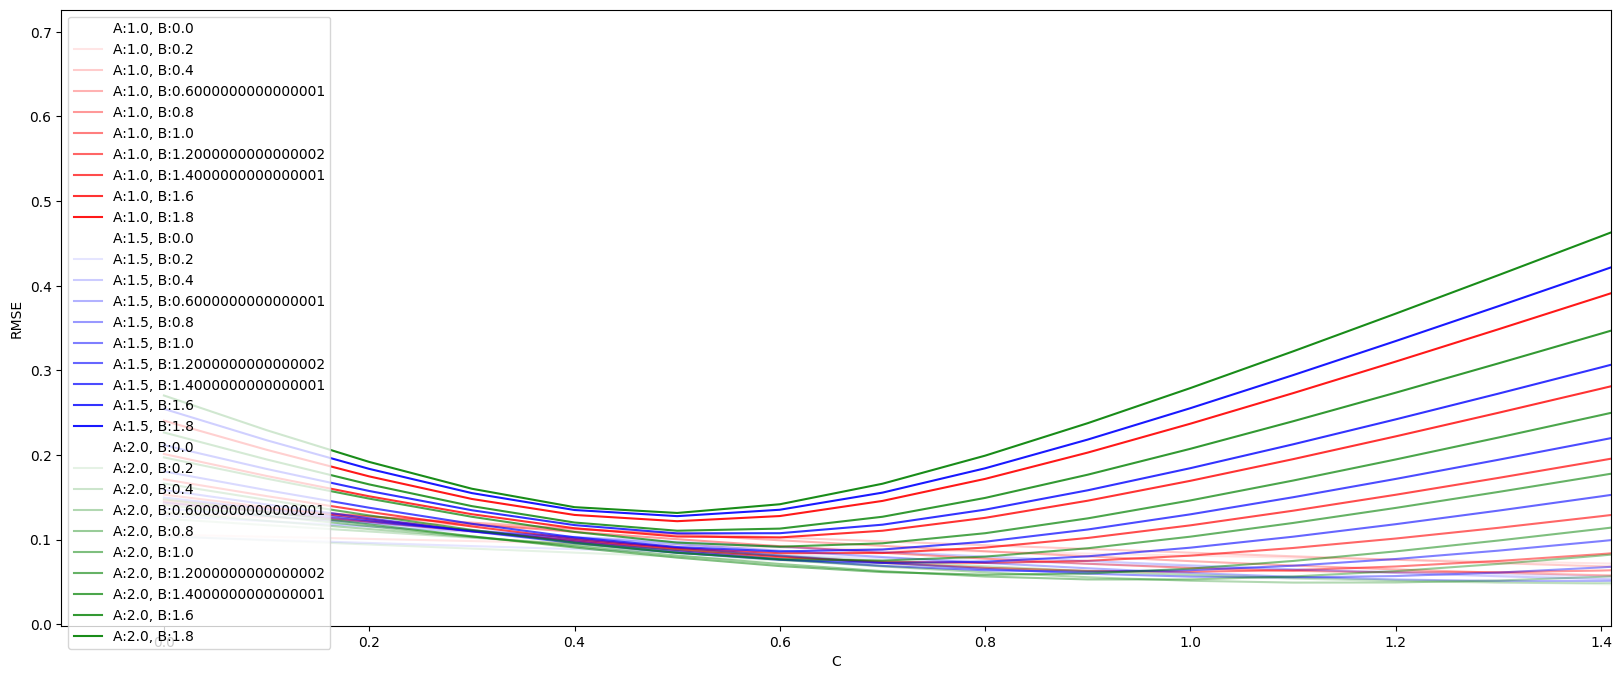

In [63]:
plt.figure(figsize = (20,8))
colors = ['r','b','g']
alphas = [0,.1,.2,.3,.4,0.5,0.6,0.7,.8,.9,1]
for i in range(3):
    ds_temp = rmse_wet_flag.isel(A=i)
    for j in range(len(B)):
        ds_temp2 = ds_temp.isel(B=j)
        plt.plot(ds_temp2.C, ds_temp2, color = colors[i],alpha = alphas[j], label = f'A:{A[i]}, B:{B[j]}' )
        
plt.xlabel('C')
plt.ylabel('RMSE')
plt.legend()
plt.xlim([-0.1,1.41])

In [8]:
rmse_wet_flag.sel(A=1)

<xarray.DataArray (B: 5, C: 5)>
array([[0.09928105, 0.08634116, 0.07464296, 0.06486181, 0.05797623],
       [0.08450897, 0.07046234, 0.06020208, 0.05585529, 0.05874956],
       [0.07215456, 0.05970017, 0.05633403, 0.06351787, 0.07840344],
       [0.07047732, 0.0658231 , 0.07621231, 0.09692244, 0.12283977],
       [0.0776078 , 0.08617115, 0.11295923, 0.14841136, 0.18768032]])
Coordinates:
    A        float64 1.0
  * B        (B) float64 0.6 0.8 1.0 1.2 1.4
  * C        (C) float64 0.6 0.8 1.0 1.2 1.4

In [3]:
# %%time
files = sorted(glob('/Users/w76m851/OneDrive - Montana State University/spicy_s1_stacks/*.nc'))

# # Create parameter space
# A = [2]
# B = [0.5]
# C = [0.44]

# ds_list = []
# rmse_default = []

# for f in files:
#     ds_name = f.split('stacks/')[-1].split('.')[0]
#     print(datetime.now(), f' -- starting {ds_name}')
#     # Open dataset 
#     ds_ = xr.open_dataset(f).load()
#     dataset = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]
#     td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(dataset.attrs['lidar-flight-time']))
#     closest_ts_idx = np.where(td == td.min())[0][0]
#     closest_ts = dataset.time[closest_ts_idx]
    
#     # Brute-force loop
#     for a in A:
#         ds = calc_delta_cross_ratio(dataset, A=a, inplace=False)
#         for b in B:
#             ds = calc_delta_gamma(ds, B=b, inplace=False)
#             for c in C:
#                 # print(f'A={a}; B={b}; C={c}')
#                 ds = clip_delta_gamma_outlier(ds)
#                 ds = calc_snow_index(ds)
#                 ds = calc_snow_index_to_snow_depth(ds, C=c, inplace=False)
#                 ds = id_newly_wet_snow(ds)
#                 ds = id_wet_negative_si(ds)
#                 ds = id_newly_frozen_snow(ds)
#                 ds = flag_wet_snow(ds)
#                 # Compare snow depths - mask wet snow
#                 mask_wet = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)) | 
#                         ds['wet_snow'].sel(time=closest_ts).astype(bool))
#                 diff_wet = ds['lidar-sd'].where(mask_wet) - ds['snow_depth'].sel(time=closest_ts).where(mask_wet)
#                 rmse_wet = float(np.sqrt((diff_wet**2).sum()/len(diff_wet.values.flatten())))
#                 rmse_default.append(rmse_wet)
#                 ds_list.append(ds_name)



# res_default = pd.Series(rmse_default, index=ds_list)
# res_default

In [ ]:
rmse_default

In [ ]:
results = sorted(glob('rmse_out/*.nc'))
res_df = pd.DataFrame(res_default, columns=['rmse_default'])
minn, a_list, b_list, c_list, = [], [], [], []
for f in results:
    if 'no_flag' in f:
        continue
    r = xr.open_dataarray(f).load()
    ds_name = f.split('rmse_out/')[-1]
    ds_name = ds_name.split('_wet')[0]
    try:
        rmse_min = r.min().values[0]
    except IndexError:
        rmse_min = float(r.min().values)
    minn.append(rmse_min)
    if r.min() > 0:
        a, b, c, = [int(i) for i in np.where(r == r.min())]
    else:
        a, b, c = 0, 0, 0 
    a_list.append(float(r['A'][a].values))
    b_list.append(float(r['B'][b].values))
    c_list.append(float(r['C'][c].values))

res_df['rmse_opt'] = minn
res_df['pct_change'] = (res_df['rmse_default'] - res_df['rmse_opt']) / res_df['rmse_default']
res_df['A_opt'] = a_list
res_df['B_opt'] = b_list
res_df['C_opt'] = c_list
res_df.loc['Frasier_2020-02-11'] = np.nan
res_df
    

In [ ]:
res_df.to_csv('rmse_out/optimization_results.csv')

In [ ]:
a, b, c, = [int(i) for i in np.where(r == r.min())]
a
